<h1><center> Protein classification using Random Forest </center></h1>

Using the new dataset without environment features

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import sh
import sys
import math
import time
import random

from tqdm import tqdm
from pprint import pprint
from pathlib import Path

from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc
from sklearn.metrics import f1_score, classification_report


import seaborn as sns; sns.set(style='ticks', font='serif')

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

In [2]:
data_dir = "/home/lab6nb/random_forests/final_dataset/"

Make header consistent throughout the files by running the following command in the terminal

```
var='"","cmi.m.Var1","cmi.m.Var2","cmi.m$value","ecmi.m$value","cc.m$value","ecc.m$value","cp.m$value","ecp.m$value","cp1.m$value","ecp1.m$value","cp2.m$value","ecp2.m$value","hcm.m$value","ehcm.m$value","rsa.m$value","ersa.m$value","scm.m$value","escm.m$value","ssp.m$value","essp.m$value","inf.m$value"'
for i in $( ls *.csv ); do
    sed -i "1s/.*/$var/" $i
done
```

In [3]:
df = pd.read_csv(data_dir + "3i4r_inf_18_df.csv", engine= 'python')

df_x = (df[["cmi.m.value","cc.m.value","cp.m.value","cp1.m.value", "cp2.m.value","hcm.m.value","rsa.m.value",
            "scm.m.value","ssp.m.value"]])

df_y = (df[["inf.m.value"]])

df_x.shape, df_y[df_y["inf.m.value"] == 1].shape

((130416, 9), (48, 1))

In [4]:
file_list = glob.glob(data_dir + "*.csv")

for file_name in file_list:
    
        df_temp = pd.read_csv(file_name)
        df_xn = (df_temp[["cmi.m.value","cc.m.value","cp.m.value","cp1.m.value","cp2.m.value",
                          "hcm.m.value","rsa.m.value",
                          "scm.m.value","ssp.m.value"]])
        df_yn = (df_temp[["inf.m.value"]])
        df_x = df_x.append(df_xn, ignore_index=True)
        df_y = df_y.append(df_yn, ignore_index=True)
        print("'%-40s' file read with %i True" %(file_name, df_temp[df_temp["inf.m.value"] == 1].shape[0]))

'/home/lab6nb/random_forests/final_dataset/1ib1_inf_18_df.csv' file read with 140 True
'/home/lab6nb/random_forests/final_dataset/1oph_inf_18_df.csv' file read with 68 True
'/home/lab6nb/random_forests/final_dataset/1xqs_inf_18_df.csv' file read with 190 True
'/home/lab6nb/random_forests/final_dataset/1s1q_inf_18_df.csv' file read with 106 True
'/home/lab6nb/random_forests/final_dataset/1h9d_inf_18_df.csv' file read with 168 True
'/home/lab6nb/random_forests/final_dataset/3aaa_inf_18_df.csv' file read with 413 True
'/home/lab6nb/random_forests/final_dataset/1rv6_inf_18_df.csv' file read with 44 True
'/home/lab6nb/random_forests/final_dataset/2c0l_inf_18_df.csv' file read with 98 True
'/home/lab6nb/random_forests/final_dataset/3cph_inf_18_df.csv' file read with 95 True
'/home/lab6nb/random_forests/final_dataset/1i4d_inf_18_df.csv' file read with 59 True
'/home/lab6nb/random_forests/final_dataset/3k75_inf_18_df.csv' file read with 55 True
'/home/lab6nb/random_forests/final_dataset/5c3l_a

In [5]:
df_x

,cmi.m.value,cc.m.value,cp.m.value,cp1.m.value,cp2.m.value,hcm.m.value,rsa.m.value,scm.m.value,ssp.m.value
0,0.475737,0.836842,0.669271,0.168317,0.020619,0.810526,0.468750,0.858431,0.6
1,0.448197,0.410526,0.346354,0.603960,0.742268,0.463158,0.156250,0.970308,0.5
2,0.537128,0.836842,0.669271,0.168317,0.020619,0.810526,0.390625,0.858431,0.5
3,0.431489,0.415789,0.291667,0.782178,0.721649,0.547368,0.312500,0.970308,0.5
4,0.121480,0.415789,0.291667,0.782178,0.721649,0.547368,0.078125,0.970308,0.5
5,0.193331,0.836842,0.669271,0.168317,0.020619,0.810526,0.156250,0.858431,0.5
6,0.176221,0.421053,0.328125,0.821782,0.855670,0.657895,0.234375,0.731177,0.5
7,0.091276,0.421053,0.328125,0.821782,0.855670,0.657895,0.078125,0.731177,0.5
8,0.085022,0.363158,0.356771,0.524752,0.783505,0.521053,0.000000,0.716331,0.5
9,0.296111,0.415789,0.291667,0.782178,0.721649,0.547368,0.078125,0.970308,0.5


In [6]:
df_x1 = df_x[df_y['inf.m.value']==0] # Dataframe x-axis with all zeros
df_y1 = df_y[df_y['inf.m.value']==0] # Dataframe y-axis with all zeros

df_x2 = df_x[df_y['inf.m.value']==1] # Dataframe x-axis with all ones
df_y2 = df_y[df_y['inf.m.value']==1] # Dataframe y-axis with all ones

In [7]:
df_x1.shape, df_y1.shape, df_x2.shape, df_y2.shape

((2126726, 9), (2126726, 1), (5039, 9), (5039, 1))

In [8]:
# Choose random indices from df_x1.index with length = 10*length of df_x2

rind = np.random.choice(np.array(df_x1.index), size=5*len(df_x2))

In [9]:
rind[1]

410066

In [10]:
df_x1.loc[rind]

,cmi.m.value,cc.m.value,cp.m.value,cp1.m.value,cp2.m.value,hcm.m.value,rsa.m.value,scm.m.value,ssp.m.value
1829710,0.239457,0.515789,0.330729,0.039604,0.041237,0.878947,0.267857,0.492577,0.3
410066,0.046033,0.500000,0.359375,0.910891,0.917526,0.968421,0.000000,0.194008,0.5
718924,0.174320,0.489474,0.315104,0.920792,0.597938,0.678947,0.000000,0.626723,0.4
47202,0.516833,0.631579,0.221354,0.841584,0.948454,0.463158,0.078125,0.843054,0.5
1659995,0.021095,0.489474,0.312500,0.801980,0.474227,0.689474,0.187500,0.704735,0.5
1769582,0.479325,0.405263,0.375000,0.217822,0.701031,0.621053,0.218750,0.626723,0.3
946249,0.060815,0.389474,0.447917,0.891089,0.587629,0.789474,0.375000,0.926038,0.5
1374104,0.004496,0.500000,0.335938,0.029703,0.804124,0.847368,0.017857,0.402969,0.6
1986968,0.499439,0.747368,0.580729,0.881188,0.680412,0.278947,0.000000,0.843054,0.4
666899,0.525406,0.836842,0.669271,0.168317,0.020619,0.810526,0.546875,0.858431,0.5


In [11]:
df_x3 = df_x1.loc[rind]
df_y3 = df_y1.loc[rind]

In [12]:
df_xc = pd.concat([df_x3, df_x2], ignore_index=True)
df_yc = pd.concat([df_y3, df_y2], ignore_index=True)

In [13]:
df_xc.shape, df_yc.shape

((30234, 9), (30234, 1))

In [14]:
x = (df_xc.as_matrix())
y = (df_yc.as_matrix())

/home/lab6nb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/home/lab6nb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [15]:
# for i in tqdm(range(len(x))):
#     x[i,0] = dict_var12[x[i,0]]
#     x[i,1] = dict_var12[x[i,1]]

In [16]:
scaler = StandardScaler().fit(x)
rescaledX = scaler.transform(x)

In [17]:
y = y.ravel()

In [18]:
X_train, X_test, y_train, y_test = train_test_split(rescaledX, y, test_size=0.2, random_state=42)

In [19]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(200, 2000, 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

lengths = [len(lst) for lst in random_grid.values()]

combs=1
for i in range(len(lengths)):
    combs *= lengths[i]
print('Total number of combinations: {:16d}'.format(combs))  


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
Total number of combinations:             4320


In [20]:
# Use the random grid to search for best hyperparameters

# Base model to tune
rf = RandomForestClassifier(class_weight='balanced')

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                               scoring='accuracy', n_iter = 100, cv = 5, verbose=1, 
                               random_state=42, n_jobs = -1)

In [21]:
# Fit the random search model
time_start = time.time()
rf_random.fit(X_train, y_train)
e = int(time.time() - time_start) # elapsed time
print("Time taken in fitting: {:02d}h:{:02d}m:{:5.2f}s".format(e//3600, e % 3600 // 60, e % 60))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/home/lab6nb/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/lab6nb/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/lab6nb/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home

/home/lab6nb/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/lab6nb/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/lab6nb/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/lab6nb/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/extern

/home/lab6nb/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/lab6nb/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/lab6nb/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/lab6nb/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/extern

Time taken in fitting: 00h:29m:38.00s


In [22]:
joblib.dump(rf_random, 'RF_random_grid_model_without_env_final.sav')

['RF_random_grid_model_without_env_final.sav']

In [23]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 110,
 'bootstrap': True}

In [24]:
best_random = rf_random.best_estimator_
random_accuracy = best_random.score(X_test, y_test)
print("Best Random model Accuracy: %.2f%%" % (random_accuracy * 100.0))

Best Random model Accuracy: 84.01%


In [25]:
y_pred = best_random.predict(X_test)

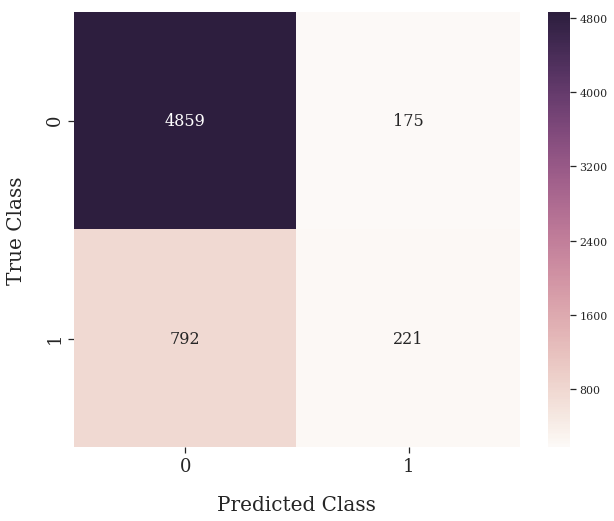

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10, 8))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
cmap = sns.cubehelix_palette(light=0.98, as_cmap=True)
unsuv_cm = pd.DataFrame(cm)
sns.heatmap(unsuv_cm, annot=True,annot_kws={"size": 16}, cmap=cmap, fmt='d')# font size
plt.xlabel("Predicted Class", fontsize=20, labelpad=20)
plt.ylabel("True Class", fontsize=20, labelpad=20)
plt.show()

Further fine-tuning near the best fitted parameters

In [27]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [90, 100, 110],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [900, 1000, 1200]
}

In [28]:
# Create a base model
rf = RandomForestClassifier(class_weight='balanced')

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, scoring='f1',
                           cv = 5, n_jobs = -1, verbose = 1)

In [29]:
time_start = time.time()
grid_search.fit(X_train, y_train);
e = int(time.time() - time_start) # elapsed time

print("Fitting Time: {:02d}h:{:02d}m:{:5.2f}s".format(e//3600, e % 3600 // 60, e % 60))

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/home/lab6nb/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/lab6nb/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/lab6nb/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Para

/home/lab6nb/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/lab6nb/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/lab6nb/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/lab6nb/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/extern

Fitting Time: 00h:47m:51.00s


In [30]:
# joblib.dump(grid_search, 'RF_grid_search_model.sav')

In [31]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 90,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'n_estimators': 1000}

In [32]:
best_grid = grid_search.best_estimator_

In [33]:
final_model = grid_search.best_estimator_

In [34]:
print('Final Model Parameters:\n')
pprint(final_model.get_params())
print('\n')
grid_final_accuracy = final_model.score(X_test, y_test)
print("Grid Final Accuracy: %.2f%%" % (grid_final_accuracy * 100.0))

Final Model Parameters:

{'bootstrap': False,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 90,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


Grid Final Accuracy: 80.87%


In [35]:
y_pred = final_model.predict(X_test)

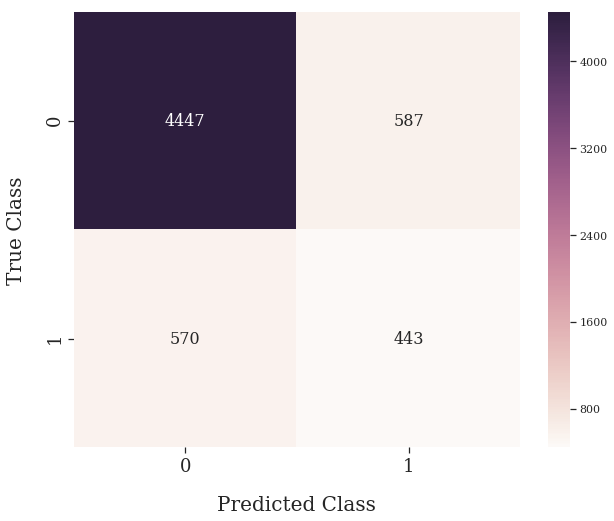

In [36]:
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10, 8))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
cmap = sns.cubehelix_palette(light=0.98, as_cmap=True)
unsuv_cm = pd.DataFrame(cm)
sns.heatmap(unsuv_cm, annot=True,annot_kws={"size": 16}, cmap=cmap, fmt='d')# font size
plt.xlabel("Predicted Class", fontsize=20, labelpad=20)
plt.ylabel("True Class", fontsize=20, labelpad=20)
plt.show()

In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.88      0.88      5034
           1       0.43      0.44      0.43      1013

   micro avg       0.81      0.81      0.81      6047
   macro avg       0.66      0.66      0.66      6047
weighted avg       0.81      0.81      0.81      6047



Feature Importance

In [38]:
fig.savefig('conf_matrix_without_env_features.svg', format= 'svg')
fig.savefig('conf_matrix_without_env_features.eps', format= 'eps')

In [40]:
importances = final_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in final_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
print(final_model.feature_importances_)

[0.16537117 0.0573905  0.06960445 0.0614018  0.06002611 0.05129824
 0.41667054 0.06698865 0.05124853]


In [41]:
'''# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))'''

'# Print the feature ranking\nprint("Feature ranking:")\n\nfor f in range(X_train.shape[1]):\n    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))'

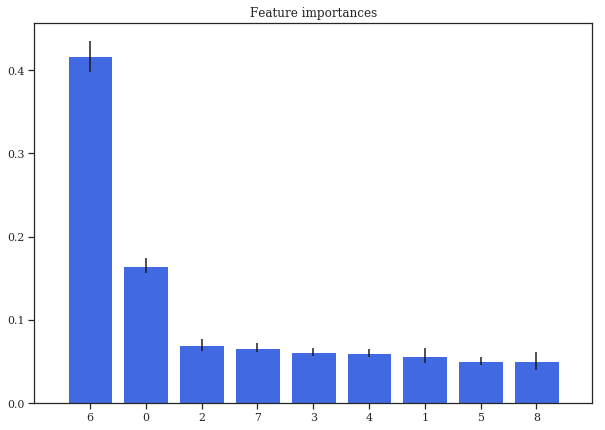

In [43]:
n_feature = 9
graph= plt.figure(figsize=(10,7))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1])[0:n_feature], importances[indices[0:n_feature]],
       color="royalblue", yerr=std[indices[0:n_feature]], align="center")
plt.xticks(range(X_train.shape[1])[0:n_feature], indices[0:n_feature])
plt.xlim([-1, n_feature])
plt.show()
graph.savefig('feature_importace_without_env_features.svg', format= 'svg')
graph.savefig('feature_importace_without_env_features.eps', format= 'eps')

In [44]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

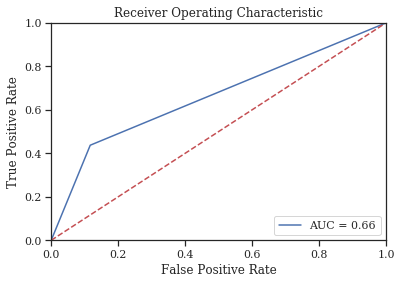

In [47]:
auc_graph= plt.figure()
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
auc_graph.savefig('auc_roc_without_env_features.svg', format= 'svg')
auc_graph.savefig('auc_roc_without_env_features.eps', format= 'eps')

#### Testing on "data_frames_01102018/3i4r_final_df.csv"

In [48]:
df = pd.read_csv(data_dir + "1gcq_inf_18_df.csv")

df_x3i4r = (df[["cmi.m.value","cc.m.value","cp.m.value","cp1.m.value", "cp2.m.value","hcm.m.value","rsa.m.value",
            "scm.m.value","ssp.m.value"]])

df_y3i4r = (df[["inf.m.value"]])

df_x3i4r.shape, df_y3i4r[df_y3i4r["inf.m.value"] == 1].shape

((4002, 9), (81, 1))

In [49]:
xtest_3i4r = np.array(df_x3i4r)
ytest_3i4r = np.array(df_y3i4r)

In [50]:
rsc_xtest_3i4r = scaler.transform(xtest_3i4r)

In [51]:
ytest_3i4r = ytest_3i4r.ravel()

In [52]:
ypred_3i4r = final_model.predict(rsc_xtest_3i4r)

In [53]:
test_prob = final_model.predict_proba(rsc_xtest_3i4r)

/home/lab6nb/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


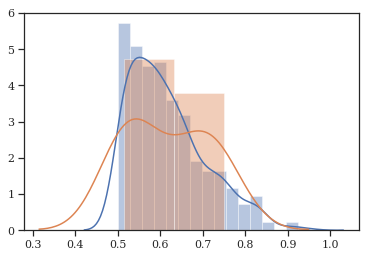

In [54]:
sns.distplot(test_prob[(ytest_3i4r == 0) & (ypred_3i4r == 1)][:,1])
sns.distplot(test_prob[(ytest_3i4r == 1) & (ypred_3i4r == 1)][:,1])
plt.show()

In [55]:
threshold=0.5
predicted_proba = final_model.predict_proba(rsc_xtest_3i4r)
predicted = (predicted_proba [:,1] >= threshold).astype('int')

In [56]:
predicted.shape, ytest_3i4r.shape

((4002,), (4002,))

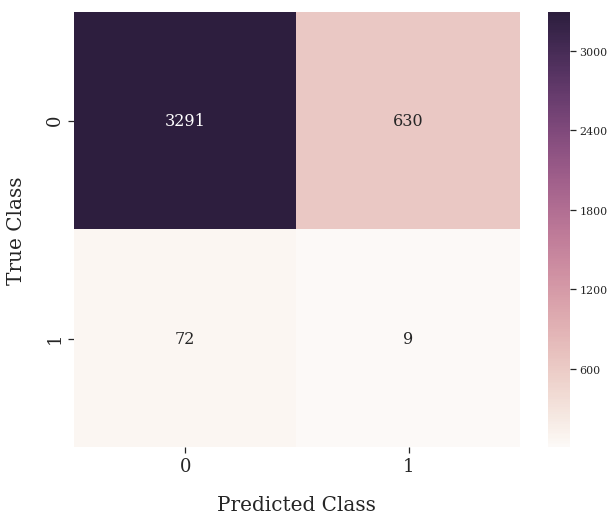

In [57]:
cm = confusion_matrix(ytest_3i4r, predicted)#ypred_3i4r)

fig, ax = plt.subplots(figsize=(10, 8))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
cmap = sns.cubehelix_palette(light=0.98, as_cmap=True)
unsuv_cm = pd.DataFrame(cm)
sns.heatmap(unsuv_cm, annot=True,annot_kws={"size": 16}, cmap=cmap, fmt='d')# font size
plt.xlabel("Predicted Class", fontsize=20, labelpad=20)
plt.ylabel("True Class", fontsize=20, labelpad=20)
plt.show()

In [58]:
print(classification_report(ytest_3i4r, predicted))#ypred_3i4r))

              precision    recall  f1-score   support

           0       0.98      0.84      0.90      3921
           1       0.01      0.11      0.03        81

   micro avg       0.82      0.82      0.82      4002
   macro avg       0.50      0.48      0.46      4002
weighted avg       0.96      0.82      0.89      4002

